In [1]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import os
from os.path import join as pjoin
from matplotlib import pyplot as plt
import random
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,AveragePooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import average 
from keras.models import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import maximum_filter1d
from matplotlib.patches import Rectangle
import tensorflow as tf
warnings.filterwarnings('ignore')

C:\Users\razer\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# first we can see what does the feature look like
def get_raw_feature():
    video_data_dir='new23feature'
    X=[]
    Y=[]
    for video in os.listdir(video_data_dir):
        each_video= pjoin(video_data_dir,video)
        ## 'C:\\videofeature\\' using
#         l=each_video.split('t_')[1]

        # 'C:\\new_video_feature\\' using
        l=each_video.split('e_')[1]
        l=l.split('.')[0]
        LABEL=int(l)
        X.append(np.load(each_video))
        Y.append(LABEL)
#     Video_label=pd.read_csv('label.csv')
# #     Video_label=np.array(Video_label)[:,:-1]
    return X,Y


## 1 Read features from 19 npy files

In [4]:
X,Y=get_raw_feature()
Video_label=pd.read_csv('newall_label.csv')
# Video_label=np.array(Video_label)[:,:-1]
print('there are ',len(X),'videos')
print('feature of video [0]',X[0].shape)
print('video [0] is from video' ,Y[0])
print(Y)

there are  23 videos
feature of video [0] (153, 14)
video [0] is from video 11
[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]


In [5]:
# Video_label

In [6]:
range_label=pd.read_csv('range_label.csv')
range_label.head()

,VideoNum,DP,BD,E,FS,A,RC
0,11,3,2,2,2,4,3
1,11,2,2,3,1,3,3
2,11,1,1,1,1,1,1
3,16,1,1,1,1,1,1
4,16,2,1,1,1,1,2


In [7]:
counts=range_label['VideoNum'].value_counts()
# counts

In [8]:
def get_review_times(videoNum):
    counts=range_label['VideoNum'].value_counts()
    times=int(counts[counts.index==videoNum])
    return times
get_review_times(192)

1

In [9]:
r_group=range_label.groupby(['VideoNum'])
r_max=r_group.max()
r_min=r_group.min()
r_max=r_max.reset_index()
r_min=r_min.reset_index()

In [10]:
def get_video_range(videoNum):
    vmax=r_max[r_max['VideoNum']==videoNum]
    vmin=r_min[r_min['VideoNum']==videoNum]
    return vmax,vmin

In [11]:
# a,i=get_video_range(11)

Video_label contains detail labels and we can use Y to index them later.

In [12]:
def getlabel(number):
    L=Video_label[Video_label['label']==number]
    L=np.array(L)[:,:-1]
    L= np.squeeze(L)
    return L
# def getlabel_addnoise(number):
#     L=Video_label[Video_label['label']==number]
#     L=np.array(L)[:,:-1]
#     L= np.squeeze(L)
#     noise=np.array([random.uniform(-0.4, 0.4) for _ in range(len(L))])
# #     print(noise)
#     return L+noise

Here we create two functions to sample video clips from each video and get their time differences.


In [13]:
def get_diff_and_hstack_to_orginal_data(X,time_lag=2,move_threshold=200):
    original=X[:-time_lag]
    modified=X[time_lag:]
    result=modified-original
    ## threshold
    # consider there was no top in the first image and it showed up in the next image
    # the difference would be huge, which was not ideal.
    # so we need to filter these extrem value 
    result[np.abs(result)>move_threshold]=0
    
    return np.hstack((X[time_lag:],result))

##from each video sample video clips with size=window_L. you can specify stride 
def make_video_clips(matrix,window_L,stride):
    alldata=[]

    total_frame=matrix.shape[0]
    index=[n for n in range(1,total_frame,stride)]
    for start_index in index:
        if start_index+window_L> total_frame:
            break
#         print(start_index)
        each_clip_data=matrix[start_index:start_index+window_L]
#         each_clip_data=np.transpose(each_clip_data)
#         print(each_clip_data.shape)
        alldata.append(each_clip_data)
    return np.array(alldata)

## 2 pre-processing the feature
make new 28-d feature and  sample video clips

In [14]:
####################################### set video clips parameters
############################################### make new 28-d feature
video_clips_length=30
time_lag=2
move_threshold=150
stride=video_clips_length

####################################### set video clips parameters
############################################### make new 28-d feature
all_data=[]
for each_video,label in zip(X,Y):

    re=get_diff_and_hstack_to_orginal_data(each_video,time_lag,move_threshold)
#     re=each_video
    video_clip=make_video_clips(re,video_clips_length,stride)
    print(video_clip.shape)
    all_data.append((video_clip))


(5, 30, 28)
(4, 30, 28)
(10, 30, 28)
(20, 30, 28)
(10, 30, 28)
(100, 30, 28)
(40, 30, 28)
(19, 30, 28)
(100, 30, 28)
(5, 30, 28)
(100, 30, 28)
(10, 30, 28)
(10, 30, 28)
(5, 30, 28)
(20, 30, 28)
(40, 30, 28)
(99, 30, 28)
(9, 30, 28)
(20, 30, 28)
(40, 30, 28)
(20, 30, 28)
(10, 30, 28)
(10, 30, 28)


So there are 19 videos and you can see how many video clips they have.

And next we will use leave one method to train the model.

## 3 prepare leave one data and give every video clips their label

In [15]:
# this function is used to stack 18 videos into a big matrix
# the dimenstion will be 
# (n1+n2..+n18,28,30)
# and the label will be (n1+n2..+n18,6)

def stack_video_clips_get_label(data,label):
    final_data=data[0]

    final_label=[getlabel(label[0]) for _ in range(final_data.shape[0])]
#     print(len(final_label))
#     print(final_data.shape)
    for i in range(1,len(data)):
        final_data=np.vstack((final_data,data[i]))
        for j in range(data[i].shape[0]):
            final_label.append(getlabel(label[i]))
    return final_data,np.array(final_label)

########## leave one and stack all video clips
def hold_out(X,Y,hold_number):
        new_label=Y.copy()
        new_data=X.copy()
        # find video n 's index
        index=new_label.index(hold_number)
        # get the video n and it's label
        X_test=new_data[index]
        test_label=getlabel(hold_number)
        y_test=np.array([test_label for _ in range(X_test.shape[0])])
#         # so we can del them 
        del new_label[index]
        del new_data[index]
#         print(new_label)
        final_data_X,final_data_Y=stack_video_clips_get_label(new_data,new_label)
        return final_data_X,X_test,final_data_Y,y_test

In [16]:
# for each col, calculate the weighted average
def get_weighted_average(df):
    length=len(df)
    top=int(1/6*length)
    bottom=length-top
    df=np.array(df)
    df=np.sort(df)
    weghted_sum=np.sum(df[:top]*(1/6))+np.sum(df[top+1:bottom]*(2/3))+np.sum(df[bottom+1:]*(1/6))
    weghted_sum=weghted_sum/length
    return weghted_sum

# make the data frame
# Plot_data is the pridect result, which will have 6 scores
def get_video_score(Plot_data,GT,poolingweight):
    weight_ave_re=[]
    mean_re=[]
    median_re=[]
    pooled_re=[]
    
    for i in Plot_data.columns:
        weight_ave=get_weighted_average(Plot_data[i])
        weight_ave_re.append(weight_ave)
        
        mean_value=np.mean(Plot_data[i])   
        mean_re.append(mean_value)
        
        median_value = np.median(Plot_data[i])
        median_re.append(median_value)
        
        weight_ave_wight=poolingweight[0]
        mean_value_wight=poolingweight[1]
        median_value_wight=poolingweight[2]
        # pooling is also a weighted average 
        pooling = (weight_ave*weight_ave_wight + mean_value*mean_value_wight + median_value*median_value_wight)
        pooled_re.append(pooling)
        
    video_result=pd.DataFrame([weight_ave_re,mean_re,median_re,pooled_re,GT])
    video_result.columns = ['DP','BD','E','FS','A','RC']
    video_result.index = ['Weighted_average', 'Mean', 'Median','Cool_pooling','Ground_truth']
    return video_result

## 3 perform leave one cross validation  


In [17]:
from keras.layers import average, concatenate,RepeatVector,Lambda,add,subtract,Activation
from keras.models import Input, Model
from keras import backend as K
from keras.layers.normalization import BatchNormalization

In [18]:
# the model we will use
def make_model_1d_3layer(l2_lambda,clip_lenth,dimension):
    input_holder = Input(shape=(clip_lenth, dimension))
    x = Conv1D(filters=8, 
                     kernel_size=15, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(input_holder)
    x = BatchNormalization()(x)

    x = Conv1D(filters=8, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=8, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x= MaxPooling1D(2,padding='same')(x)
    
    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
#     x = GlobalMaxPooling1D()(x)
#     x = Flatten()(x)

#####_______________________________________________________________________
    u = GlobalMaxPooling1D()(x)
    u_broadcast=RepeatVector(x.shape[1])(u)
    
    def op(inputs):
        x, y = inputs
        return K.pow((x - y), 2) 

    Z=Lambda(op)([u_broadcast,x])

    v = GlobalMaxPooling1D()(Z)
    x = concatenate([u,v])
    
#####_______________________________________________________________________
#     x = Dense(16, 
#               activation='relu',
#               kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#             )(x)

#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers
    
#     x = Dense(6, 
#               activation='sigmoid', 
#               kernel_initializer='glorot_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
    
#####_______________________________________________________________________  
#     x = Dense(16,activation='relu',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers


#     x = Dense(32,activation='relu',kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers

#####______________________________Multi task_________________________________________  
# ['DP','BD','E','FS','A','RC']
    number_of_N=16
    DP=0.2
    
    y1 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Dropout(DP)(y1) # add some dropout for regularization after conv layers
    y1= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='DP'
#              kernel_regularizer=l2(l2_lambda)
             )(y1)

    y2 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = Dropout(DP)(y2) # add some dropout for regularization after conv layers
    y2= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='BD'
#              kernel_regularizer=l2(l2_lambda)
             )(y2)
    
    y3 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)
    y3 = Dropout(DP)(y3) # add some dropout for regularization after conv layers
    y3= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='E'
#              kernel_regularizer=l2(l2_lambda)
             )(y3)

    y4 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)
    y4 = Dropout(DP)(y4) # add some dropout for regularization after conv layers
    y4= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='FS'
#              kernel_regularizer=l2(l2_lambda)
             )(y4)
    
    y5 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)
    y5 = Dropout(DP)(y5) # add some dropout for regularization after conv layers
    y5= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='A'
#              kernel_regularizer=l2(l2_lambda)
             )(y5)
    
    y6 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y6 = BatchNormalization()(y6)
    y6 = Activation('relu')(y6)
    y6 = Dropout(DP)(y6) # add some dropout for regularization after conv layers
    y6= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='RC'
#              kernel_regularizer=l2(l2_lambda)
             )(y6)
#####______________________________Multi task_________________________________________  


    model = Model(inputs=input_holder,outputs=[y1,y2,y3,y4,y5,y6])
# ['DP','BD','E','FS','A','RC']
    losses = {
        "DP": "mean_squared_error",
        "BD": "mean_squared_error",
        "E": "mean_squared_error",
        "FS": "mean_squared_error",
        "A": "mean_squared_error",
        "RC": "mean_squared_error",
    }
    model.compile(#loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error' 'mean_absolute_percentage_error'
                  loss=losses, 
              optimizer='adam') # 'adadelta' 'rmsprop'                  
#     model.summary()
    return model
te=make_model_1d_3layer(0.001,30,28)

In [34]:
# the model we will use
def make_model_1d(l2_lambda,clip_lenth,dimension,ss):
    input_holder = Input(shape=(clip_lenth, dimension))
    x = Conv1D(filters=8, 
                     kernel_size=15, 
                     strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(input_holder)
    x = BatchNormalization()(x)

    x = Conv1D(filters=8, 
                     kernel_size=10, 
               strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
#     x = Conv1D(filters=8, 
#                      kernel_size=5, 
#                      padding='same',
#                      activation='relu', 
#                      input_shape=(clip_lenth, dimension),
#                      kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x= MaxPooling1D(2,padding='same')(x)
    
    x = Conv1D(filters=16, 
                     kernel_size=5, 
               strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=16, 
                     kernel_size=5, 
               strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)
#     x = Conv1D(filters=16, 
#                      kernel_size=5, 
#                      padding='same',
#                      activation='relu', 
#                      input_shape=(clip_lenth, dimension),
#                      kernel_regularizer=l2(l2_lambda))(x)

#     x = GlobalMaxPooling1D()(x)
#     x = Flatten()(x)

#####_______________________________________________________________________
    u = GlobalMaxPooling1D()(x)
    u_broadcast=RepeatVector(x.shape[1])(u)
    
    def op(inputs):
        x, y = inputs
        return K.pow((x - y), 2) 

    Z=Lambda(op)([u_broadcast,x])

    v = GlobalMaxPooling1D()(Z)
    x = concatenate([u,v])
    
#####_______________________________________________________________________
#     x = Dense(16, 
#               activation='relu',
#               kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#             )(x)

#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers
    
#     x = Dense(6, 
#               activation='sigmoid', 
#               kernel_initializer='glorot_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
    
#####_______________________________________________________________________  
#     x = Dense(16,activation='relu',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers


#     x = Dense(32,activation='relu',kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers

#####______________________________Multi task_________________________________________  
# ['DP','BD','E','FS','A','RC']
    number_of_N=16
    DP=0.2
    
    y1 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Dropout(DP)(y1) # add some dropout for regularization after conv layers
    y1= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='DP'
#              kernel_regularizer=l2(l2_lambda)
             )(y1)

    y2 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = Dropout(DP)(y2) # add some dropout for regularization after conv layers
    y2= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='BD'
#              kernel_regularizer=l2(l2_lambda)
             )(y2)
    
    y3 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)
    y3 = Dropout(DP)(y3) # add some dropout for regularization after conv layers
    y3= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='E'
#              kernel_regularizer=l2(l2_lambda)
             )(y3)

    y4 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)
    y4 = Dropout(DP)(y4) # add some dropout for regularization after conv layers
    y4= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='FS'
#              kernel_regularizer=l2(l2_lambda)
             )(y4)
    
    y5 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)
    y5 = Dropout(DP)(y5) # add some dropout for regularization after conv layers
    y5= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='A'
#              kernel_regularizer=l2(l2_lambda)
             )(y5)
    
    y6 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y6 = BatchNormalization()(y6)
    y6 = Activation('relu')(y6)
    y6 = Dropout(DP)(y6) # add some dropout for regularization after conv layers
    y6= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='RC'
#              kernel_regularizer=l2(l2_lambda)
             )(y6)
#####______________________________Multi task_________________________________________  


    model = Model(inputs=input_holder,outputs=[y1,y2,y3,y4,y5,y6])
# ['DP','BD','E','FS','A','RC']
    losses = {
        "DP": "mean_squared_error",
        "BD": "mean_squared_error",
        "E": "mean_squared_error",
        "FS": "mean_squared_error",
        "A": "mean_squared_error",
        "RC": "mean_squared_error",
    }
    model.compile(#loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error' 'mean_absolute_percentage_error'
                  loss=losses, 
              optimizer='adam') # 'adadelta' 'rmsprop'                  
#     model.summary()
    return model
te=make_model_1d(0.001,30,28,1)

In [35]:
# from IPython.display import SVG
# from keras.utils import plot_model
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(te).create(prog='dot', format='svg'))

In [36]:
te.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 30, 28)       0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 30, 8)        3368        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 30, 8)        32          conv1d_27[0][0]                  
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 30, 8)        648         batch_normalization_63[0][0]     
__________________________________________________________________________________________________
batch_norm

In [22]:
# plot_model(te, to_file='model1.png')

In [23]:
# customized data generator
def generator_noise(data, label, batch_size=64,noise_range=0.1):
    while 1:
        DP = []  
        BD = []
        E = []
        FS = []
        A = []
        RC = []
        rows = np.random.randint(0, data.shape[0], size=batch_size)

        samples = data[rows]
        y=label[rows]
        noise=np.random.uniform(low=-noise_range, high=noise_range, size=(y.shape[0],y.shape[1]))
        y=y+noise
        for i in range(len(y)):
            DP.append(y[i][0])
            BD.append(y[i][1])
            E.append(y[i][2])
            FS.append(y[i][3])
            A.append(y[i][4])
            RC.append(y[i][5])
        labels = [np.array(DP),np.array(BD),np.array(E),np.array(FS), np.array(A),np.array(RC)]
        yield samples,labels
        
def generator(data, label, batch_size=64):
    while 1:
        DP = []  
        BD = []
        E = []
        FS = []
        A = []
        RC = []
        rows = np.random.randint(0, data.shape[0], size=batch_size)

        samples = data[rows]
        y=label[rows]
#         noise=np.random.uniform(low=-0.5, high=0.5, size=(y.shape[0],y.shape[1]))
#         y=y+noise
        for i in range(len(y)):
            DP.append(y[i][0])
            BD.append(y[i][1])
            E.append(y[i][2])
            FS.append(y[i][3])
            A.append(y[i][4])
            RC.append(y[i][5])
        labels = [np.array(DP),np.array(BD),np.array(E),np.array(FS), np.array(A),np.array(RC)]
        yield samples,labels

In [24]:
def test_hold_out(model_name,hold_out_number,E,show_result=False,l2lambd=0.001,noise_range=0.1,poolingweight=[0.2,0.4,0.4],stride=1,filtersize=3):
    # using leave one cv to get train/test data
    X_train, X_test, y_train, y_test=hold_out(all_data,Y,hold_out_number)
    
    # scale all the value to 0-1
    X_train=X_train/640-0.5
    X_test=X_test/640-0.5
    y_train=y_train/5
    y_test=y_test/5
#     y_train=y_train
#     y_test=y_test
    # print(X_train.shape,y_train.shape)
    # print(X_test.shape,y_test.shape)

    sample_of_trainningdata=X_train.shape[0]
    sample_of_testdata=X_test.shape[0]

    batch_size=128

    train_gen=generator_noise(X_train, y_train, batch_size,noise_range)
    val_gen=generator(X_test, y_test, batch_size)
    
    #prepare for inout shape
    clip_lenth=X_train.shape[1]
    dimension=X_train.shape[2]
    
    if model_name=='CNN':    
        model=make_model_1d(l2lambd,clip_lenth,dimension,stride)
    if model_name =='CNN3':
        model=make_model_1d_3layer(l2lambd,clip_lenth,dimension)
        
    model_h=model.fit_generator(train_gen,
                        steps_per_epoch=sample_of_trainningdata//batch_size,
                        epochs=E,
                        validation_data=val_gen,
                       validation_steps=sample_of_testdata//batch_size +1 ,
                        verbose=0 )
  
    GT=list(getlabel(hold_out_number))

    #get pridect result
    predict=model.predict(X_test)
    data={}
    task=['DP','BD','E','FS','A','RC']

    for i in range(len(predict)):
        data[task[i]]=np.squeeze(predict[i])

#         Plot_data=pd.DataFrame(predict,columns=['DP','BD','E','FS','A','RC'])
    Plot_data=pd.DataFrame(data)
    Plot_data=Plot_data*5
    filtered_data=Plot_data.copy()
    for index, row in filtered_data.iteritems():
#         filtered_data[index]=gaussian_filter1d(filtered_data[index], 0.6)
        filtered_data[index]=maximum_filter1d(filtered_data[index],mode='nearest',size= filtersize)
#         maximum_filter1d([2, 8, 0, 4, 1, 9, 9, 0], size=3)


################# get diff
    video_result=get_video_score(Plot_data,GT,poolingweight)
    gt=video_result.iloc[4]
    re=video_result.iloc[3]
    
    each_diff=list(np.abs(re-gt))
    each_diff_residual=list(re-gt)
    
    each_diff_round=list(np.abs(np.round(re)-gt))
    each_diff_round_residual=list(np.round(re)-gt)
    
    
    filtered_video_result=get_video_score(filtered_data,GT,poolingweight)
    fi_re=filtered_video_result.iloc[3]
    
    fi_each_diff=list(np.abs(fi_re-gt))
    fi_each_diff_residual=list(fi_re-gt)
    
    fi_each_diff_round=list(np.abs(np.round(fi_re)-gt))
    fi_each_diff_round_residual=list(np.round(fi_re)-gt)
    
    
    diff=[each_diff,each_diff_round,fi_each_diff,fi_each_diff_round]
    residual=[each_diff_residual,each_diff_round_residual,fi_each_diff_residual,fi_each_diff_round_residual]
    
###########################    

    if show_result:
        ax=plt.figure(figsize=(12,14))
        ax = plt.subplot(421)
        ax.plot(model_h.history['loss'])
        plt.ylabel('Training Loss')
        plt.xlabel('epochs')

        ax = plt.subplot(422)
        ax.plot(model_h.history['val_loss'])
        plt.ylabel('valadation Loss')
        plt.xlabel('epochs')
#         print('loss',model_h.history['val_loss'][-1])
    
        y=[x for x in range(1,7)]
        ax = plt.subplot(423)
        Plot_data.plot.box(ax=ax)
        ax.plot(y, re, label='predict')
        ax.plot(y, gt, label='ground truth')

        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        ax.legend()

        ax = plt.subplot(424)
        Plot_data.plot(ax=ax)
#         ax.plot(Plot_data)
        ax.legend(['DP','BD','E','FS','A','RC'],bbox_to_anchor=(1,1))
#         ax.plot(Plot_data.BD)
        plt.ylabel('Gear Score')
        plt.xlabel('Video clips length')
        
        
        ax = plt.subplot(425)
        filtered_data.plot.box(ax=ax)
        ax.plot(y, fi_re, label='predict')
        ax.plot(y, gt, label='ground truth')
        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        ax.legend()
 
        ax = plt.subplot(426)
        filtered_data.plot(ax=ax)
#         ax.plot(Plot_data)
        ax.legend(['DP','BD','E','FS','A','RC'],bbox_to_anchor=(1,1))
#         ax.plot(Plot_data.BD)
        plt.ylabel('Gear Score')
        plt.xlabel('Video clips length')


        ax = plt.subplot(427)
        times=get_review_times(hold_out_number)
        ax.plot(y, np.round(re), label='predict-round')
        ax.plot(y, re, label='predict')
        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        
        if times>1:        
            vmax,vmin=get_video_range(hold_out_number)

            it=1
            for types in ['DP','BD','E','FS','A','RC']:
                Range=vmax[types]-vmin[types]
                rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
                ax.add_patch(rect)   
                it=it+1
        else:
#             new_re=np.round(video_result.iloc[3])
#             ax.plot(y, new_re, label='predict-round')
            ax.plot(y, gt, label='ground truth')        
        labels=['','DP','BD','E','FS','A','RC']
        ax.set_xticklabels(labels)
        ax.legend()
        
        ax = plt.subplot(428)
        times=get_review_times(hold_out_number)
        ax.plot(y, np.round(fi_re), label='predict-round')
        ax.plot(y, fi_re, label='predict')
        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        
        if times>1:        
            vmax,vmin=get_video_range(hold_out_number)

            it=1
            for types in ['DP','BD','E','FS','A','RC']:
                Range=vmax[types]-vmin[types]
                rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
                ax.add_patch(rect)   
                it=it+1
        else:
#             new_re=np.round(video_result.iloc[3])
#             ax.plot(y, new_re, label='predict-round')
            ax.plot(y, gt, label='ground truth')        
        labels=['','DP','BD','E','FS','A','RC']
        ax.set_xticklabels(labels)
        ax.legend()        

#         plt.savefig(str(hold_out_number)+'result.png')
        plt.show()
        
    return model_h.history['val_loss'][-1],diff,residual


In [25]:
print(Y)

[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]


In [26]:
def get_swarm_data(Diff_plot):
    name=['DP','BD','E','FS','A','RC']
    err=[]
    typen=[]
    for n in name:
        for record in Diff_plot[n]:
            err.append(record)
            typen.append(n)

    swarm_data = {'err': err, 'score_type':typen}
    swarm_data = pd.DataFrame(data=swarm_data)
    return swarm_data


In [27]:
def model_slection(model_name,E,l2lam,noise_range,poolingweight,stride,filtersize):  
    All_diff=[]
    All_residual=[]
#     E=20
#     l2lam=0.01
#     noise_range=0.1
    show_result=False


    diff_loss=0
    diff_round_loss=0
    fi_diff_loss=0
    fi_diff_round_loss=0
    
#     for i in [11]:
    for i in Y:
        print('video',i,end=' ')
        loss,each_diff,fi_each_residual=test_hold_out(model_name,i,E,show_result,l2lam,noise_range,poolingweight,stride,filtersize)

        diff_loss+=np.sum(each_diff[0])
        diff_round_loss+=np.sum(each_diff[1])
        fi_diff_loss+=np.sum(each_diff[2])
        fi_diff_round_loss+=np.sum(each_diff[3])
        
        All_diff.append(each_diff)
        All_residual.append(fi_each_residual)


    weight=''
    for i in poolingweight:
        weight+=str(i)+'_'
        
    out_name='newdata//Diff'+str(E)+'_'+str(l2lam)+'_'+str(noise_range)+'_'+str(weight)+'fsize'+str(filtersize)+'.npy'
    np.save(out_name,All_diff)
    out_name='newdata//Residual'+str(E)+'_'+str(l2lam)+'_'+str(noise_range)+'_'+str(weight)+'fsize'+str(filtersize)+'.npy'
    np.save(out_name,All_residual)
    print()
    print('Baseline== 164')
    print('diff_loss:',diff_loss)
    print('diff_round_loss:',diff_round_loss)
    print('fi_diff_loss:',fi_diff_loss)
    print('fi_diff_round_loss:',fi_diff_round_loss)
    
    K.clear_session()
    tf.reset_default_graph()

In [28]:
# show_result=False
# E=15
# model_name='CNN'
# l2lam=0.0001
# noise_range=0.1
# poolingweight=[0,1,0]
# filtersize=5
# loss,each_diff,fi_each_residual=test_hold_out(model_name,143,E,show_result,l2lam,noise_range,poolingweight,filtersize)

In [29]:
%%time
# E=20
# l2lam=0.01
# noise_range=0.1
# poolingweight=[0.333333,0.333333,0.333333]
# stride=1
# total_loss=0
# model_name='CNN'
model_slection('CNN',20,0.01,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 142.03569081372208
diff_round_loss: 141.333333332
fi_diff_loss: 135.1862928980011
fi_diff_round_loss: 135.666666666
Wall time: 6min 5s


In [30]:
model_slection('CNN',20,0.01,0.1,[0.333333,0.333333,0.333333],2,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 166.4463711599862
diff_round_loss: 164.999999998
fi_diff_loss: 153.51452881161404
fi_diff_round_loss: 152.666666666


In [31]:
model_slection('CNN',20,0.01,0.1,[0.333333,0.333333,0.333333],3,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 163.72948872203872
diff_round_loss: 165.0
fi_diff_loss: 160.32915787262192
fi_diff_round_loss: 155.666666666


In [32]:
model_slection('CNN',20,0.01,0.1,[0.333333,0.333333,0.333333],1,3)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 142.8983206045234
diff_round_loss: 141.666666666
fi_diff_loss: 142.25125388044555
fi_diff_round_loss: 143.0


In [33]:
model_slection('CNN',20,0.01,0.1,[0.333333,0.333333,0.333333],2,3)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 154.16083302255083
diff_round_loss: 149.666666666
fi_diff_loss: 151.7830624147648
fi_diff_round_loss: 158.33333333200002


In [34]:
model_slection('CNN',20,0.01,0.1,[0.333333,0.333333,0.333333],3,3)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 146.97172431303437
diff_round_loss: 151.0
fi_diff_loss: 136.6601250155236
fi_diff_round_loss: 133.999999998


In [35]:
model_slection('CNN',20,0.001,0.2,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 156.12574190863592
diff_round_loss: 147.666666666
fi_diff_loss: 144.8847275661052
fi_diff_round_loss: 144.0


In [36]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,1,0],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 167.2787208557129
diff_round_loss: 173.0
fi_diff_loss: 185.60398379894986
fi_diff_round_loss: 191.33333333200002
Wall time: 6min 9s


In [37]:
%%time
model_slection('CNN',20,0.0001,0.1,[1,0,0],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 211.62591135324905
diff_round_loss: 213.33333333399997
fi_diff_loss: 182.77349142989453
fi_diff_round_loss: 181.33333333599998
Wall time: 6min 10s


In [38]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,0,1],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 163.11514592170715
diff_round_loss: 161.666666666
fi_diff_loss: 182.98263355162848
fi_diff_round_loss: 182.333333334
Wall time: 6min 9s


In [39]:
model_slection('CNN',10,0.00001,0.2,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 141.43472963546492
diff_round_loss: 143.666666666
fi_diff_loss: 127.16933331899895
fi_diff_round_loss: 123.0


In [40]:
model_slection('CNN',10,0.00001,0.2,[0.333333,0.333333,0.333333],2,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 180.72087056905787
diff_round_loss: 181.666666666
fi_diff_loss: 171.55977066503277
fi_diff_round_loss: 171.0


In [41]:
model_slection('CNN',10,0.001,0.2,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 182.25477354654893
diff_round_loss: 176.333333332
fi_diff_loss: 164.8200260718052
fi_diff_round_loss: 161.666666666


In [42]:
%%time
model_slection('CNN',10,0.01,0.25,[0.333333,0.333333,0.333333],3,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 152.9126535647738
diff_round_loss: 156.0
fi_diff_loss: 149.72918444539155
fi_diff_round_loss: 152.0
Wall time: 5min 48s


In [43]:
%%time
model_slection('CNN',15,0.001,0.2,[0.333333,0.333333,0.333333],1,4)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 154.46434830335758
diff_round_loss: 154.999999998
fi_diff_loss: 158.45633413496137
fi_diff_round_loss: 157.0
Wall time: 6min 1s


In [44]:
model_slection('CNN',15,0.01,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 173.87563384794453
diff_round_loss: 174.0
fi_diff_loss: 168.5678198091921
fi_diff_round_loss: 167.33333333200002


In [45]:
%%time
model_slection('CNN',19,0.01,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 162.6910085655369
diff_round_loss: 160.666666666
fi_diff_loss: 152.91260275055524
fi_diff_round_loss: 151.66666666600003
Wall time: 6min 8s


In [46]:
%%time
model_slection('CNN',18,0.01,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 153.683417073522
diff_round_loss: 153.0
fi_diff_loss: 157.42306132337828
fi_diff_round_loss: 154.333333332
Wall time: 6min 7s


In [47]:
%%time
model_slection('CNN',17,0.01,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 173.2136124659999
diff_round_loss: 170.0
fi_diff_loss: 174.85424075573974
fi_diff_round_loss: 173.33333333200002
Wall time: 6min 5s


In [48]:
%%time
model_slection('CNN',16,0.01,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 168.04038201649854
diff_round_loss: 175.666666666
fi_diff_loss: 154.23033737223113
fi_diff_round_loss: 154.666666666
Wall time: 6min 1s


In [49]:
%%time
model_slection('CNN',15,0.01,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 182.44208617489667
diff_round_loss: 177.666666666
fi_diff_loss: 166.47914686774914
fi_diff_round_loss: 168.0
Wall time: 5min 58s


In [50]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,1,0],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 155.80641911360516
diff_round_loss: 162.66666666600003
fi_diff_loss: 175.27386716934933
fi_diff_round_loss: 174.66666666600003
Wall time: 6min 9s


In [51]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,1,0],2,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 151.83589426609768
diff_round_loss: 149.666666666
fi_diff_loss: 196.45211712452664
fi_diff_round_loss: 201.66666666600003
Wall time: 6min 9s


In [52]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,1,0],3,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 145.1973439157009
diff_round_loss: 145.33333333200002
fi_diff_loss: 164.8626592549969
fi_diff_round_loss: 162.66666666600003
Wall time: 6min 11s


In [53]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,1,0],1,3)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 164.01834392547607
diff_round_loss: 165.0
fi_diff_loss: 174.03176554110755
fi_diff_round_loss: 175.66666666600003
Wall time: 6min 9s


In [54]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,1,0],2,3)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 150.55153103536153
diff_round_loss: 145.333333332
fi_diff_loss: 171.8576768431355
fi_diff_round_loss: 171.66666666600003
Wall time: 6min 15s


In [55]:
%%time
model_slection('CNN',20,0.0001,0.1,[0,1,0],3,3)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 158.22796752685525
diff_round_loss: 160.666666668
fi_diff_loss: 144.91345523661158
fi_diff_round_loss: 138.333333332
Wall time: 6min 13s


In [56]:
%%time
model_slection('CNN',19,0.005,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 166.5176547861269
diff_round_loss: 163.66666666600003
fi_diff_loss: 151.12232283052845
fi_diff_round_loss: 145.666666666
Wall time: 6min 13s


In [57]:
%%time
model_slection('CNN',19,0.02,0.1,[0.333333,0.333333,0.333333],1,5)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 179.37737988796857
diff_round_loss: 179.0
fi_diff_loss: 170.61138637235035
fi_diff_round_loss: 170.0
Wall time: 6min 12s


In [58]:
%%time
model_slection('CNN',19,0.01,0.1,[0.333333,0.333333,0.333333],1,4)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 151.2280102636278
diff_round_loss: 149.0
fi_diff_loss: 154.41317095365315
fi_diff_round_loss: 150.666666666
Wall time: 6min 13s


In [59]:
%%time
model_slection('CNN',19,0.01,0.1,[0.333333,0.333333,0.333333],1,3)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 166.3893220396817
diff_round_loss: 169.33333333200002
fi_diff_loss: 165.2472527182777
fi_diff_round_loss: 167.33333333200002
Wall time: 6min 13s


In [60]:
%%time
model_slection('CNN',19,0.01,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 152.41752633905872
diff_round_loss: 151.0
fi_diff_loss: 134.82328491891093
fi_diff_round_loss: 140.333333332
Wall time: 6min 11s


In [61]:
%%time
model_slection('CNN',18,0.01,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 149.8262386664044
diff_round_loss: 156.666666666
fi_diff_loss: 147.9908008907609
fi_diff_round_loss: 148.666666666
Wall time: 6min 5s


In [62]:
%%time
model_slection('CNN',17,0.01,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 154.07664504042705
diff_round_loss: 152.666666666
fi_diff_loss: 148.14139946587943
fi_diff_round_loss: 147.0
Wall time: 6min 3s


In [63]:
%%time
model_slection('CNN',16,0.01,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 178.46006006057718
diff_round_loss: 178.666666666
fi_diff_loss: 166.69020079913088
fi_diff_round_loss: 167.66666666600003
Wall time: 6min


In [64]:
%%time
model_slection('CNN',15,0.01,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 180.79828111527382
diff_round_loss: 175.0
fi_diff_loss: 169.06046668686932
fi_diff_round_loss: 173.0
Wall time: 6min


In [65]:
%%time
model_slection('CNN',15,0.005,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 161.43622599147025
diff_round_loss: 161.666666666
fi_diff_loss: 150.10107800930138
fi_diff_round_loss: 147.666666666
Wall time: 5min 57s


In [66]:
%%time
model_slection('CNN',15,0.005,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 159.85437406871662
diff_round_loss: 160.0
fi_diff_loss: 160.90263200940356
fi_diff_round_loss: 169.66666666600003
Wall time: 5min 58s


In [67]:
%%time
model_slection('CNN',10,0.005,0.1,[0.333333,0.333333,0.333333],1,6)

video 11 video 113 video 130 video 143 video 152 video 16 video 164 video 171 video 176 video 192 video 194 video 207 video 236 video 237 video 240 video 253 video 257 video 258 video 49 video 59 video 74 video 78 video 91 
Baseline== 164
diff_loss: 156.8167338169217
diff_round_loss: 157.33333333200002
fi_diff_loss: 150.71863266335194
fi_diff_round_loss: 147.333333332
Wall time: 5min 44s


In [68]:
# test=PLOTDATA.copy()
# for index, row in test.iteritems():
#     test[index]=gaussian_filter1d(test[index], 1)
# test.plot()
# model_slection(10,0.0005,0.2,[0.333333,0.333333,0.333333])

video 11 

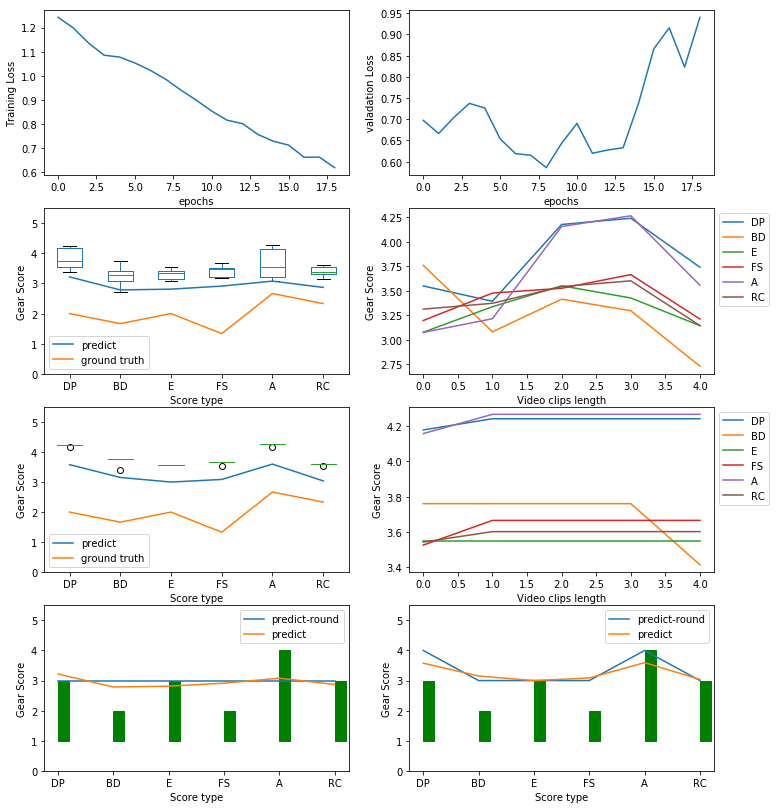

video 113 

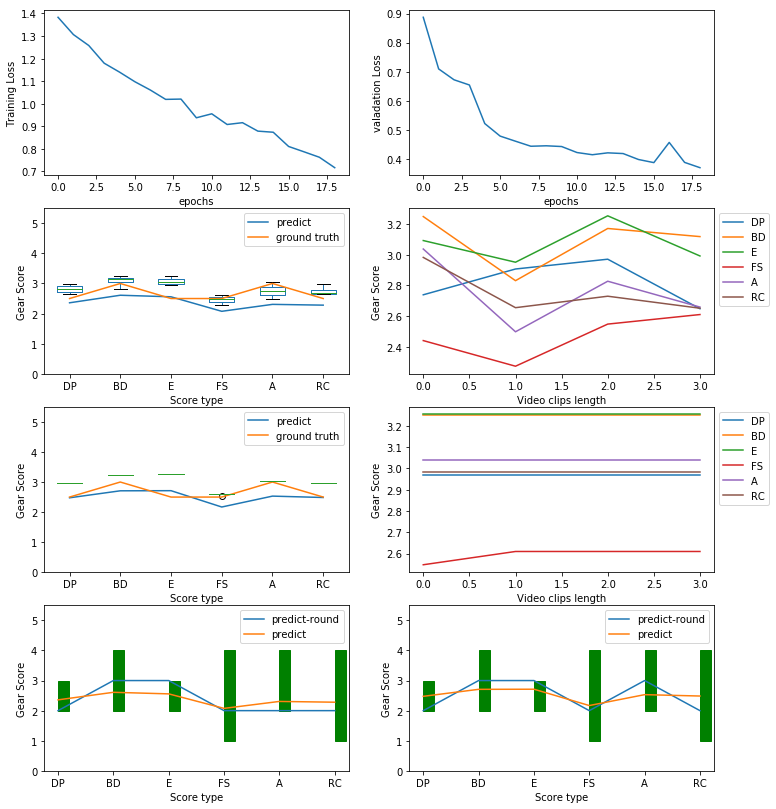

video 130 

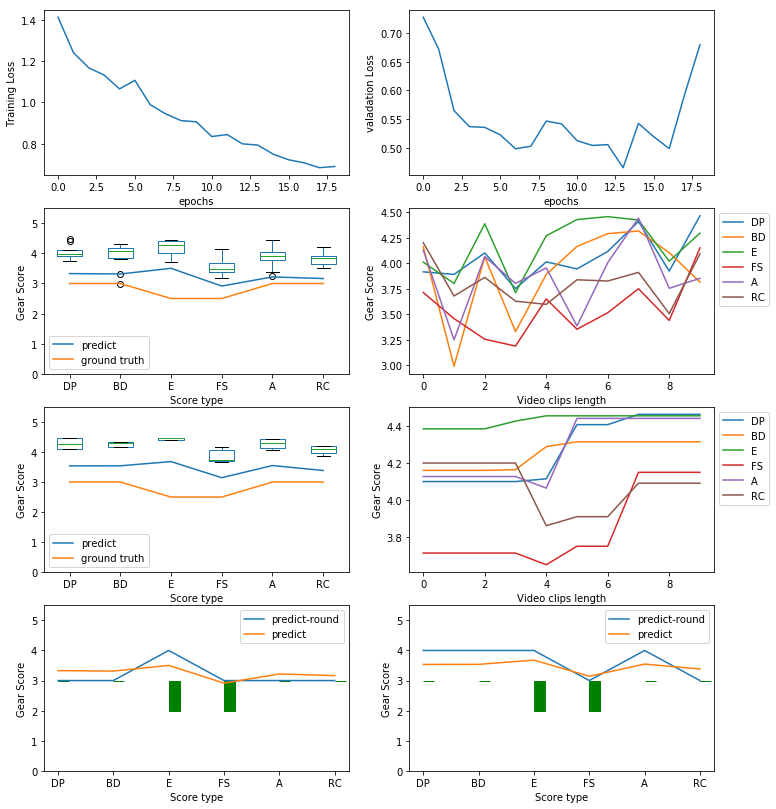

video 143 

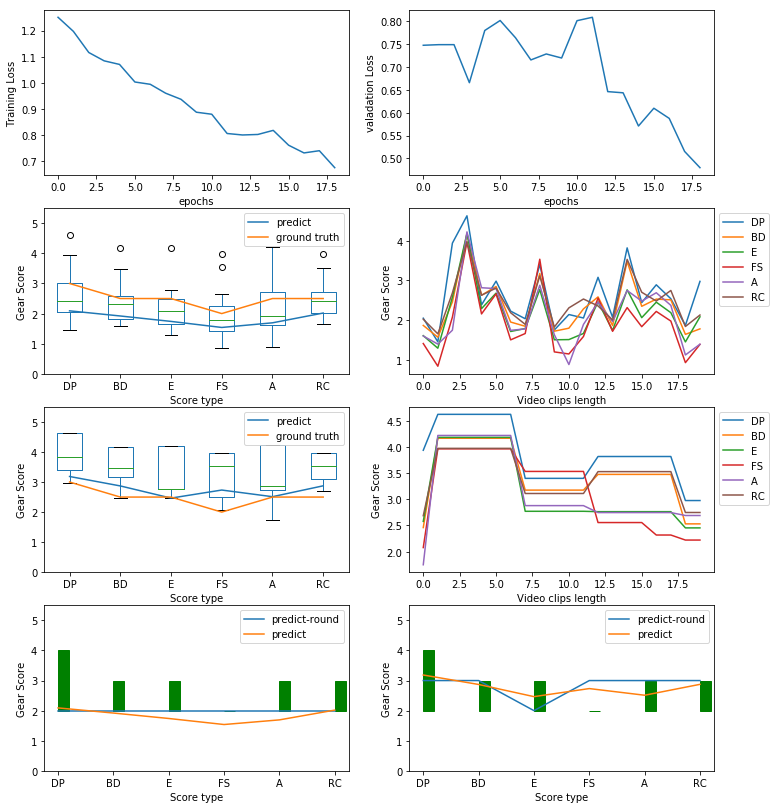

video 152 

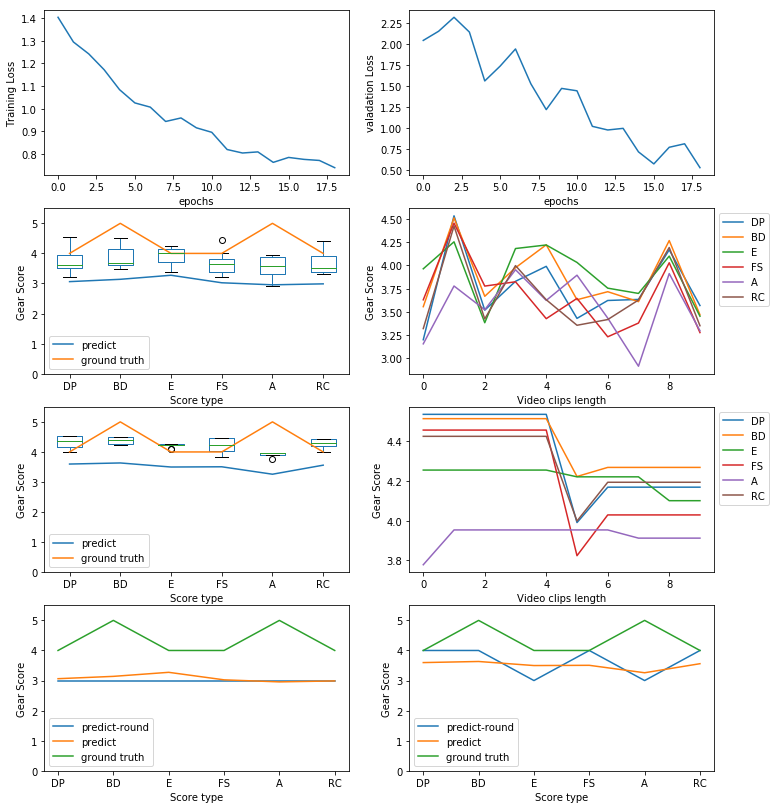

video 16 

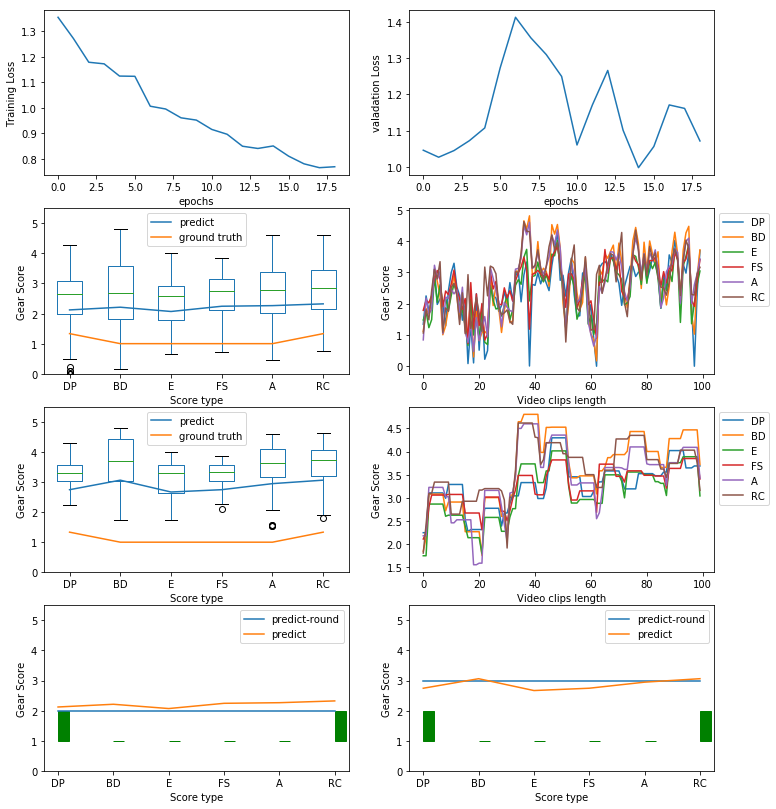

video 164 

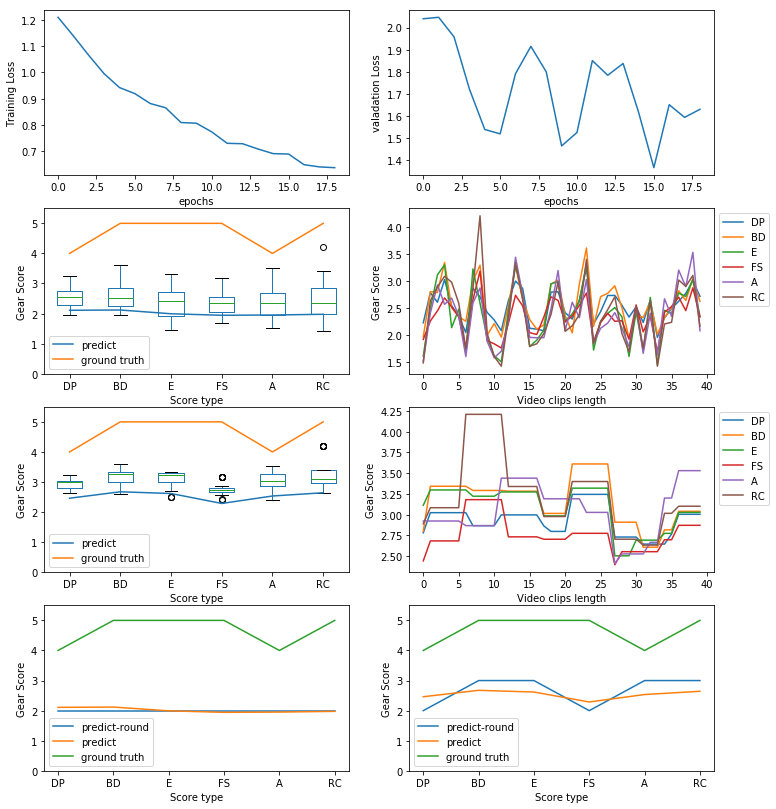

video 171 

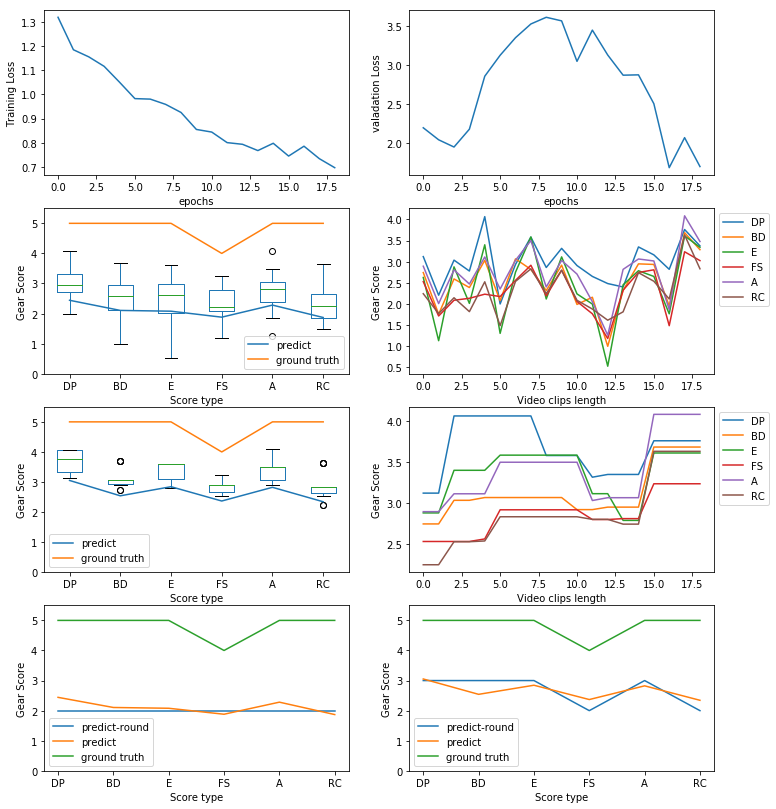

video 176 

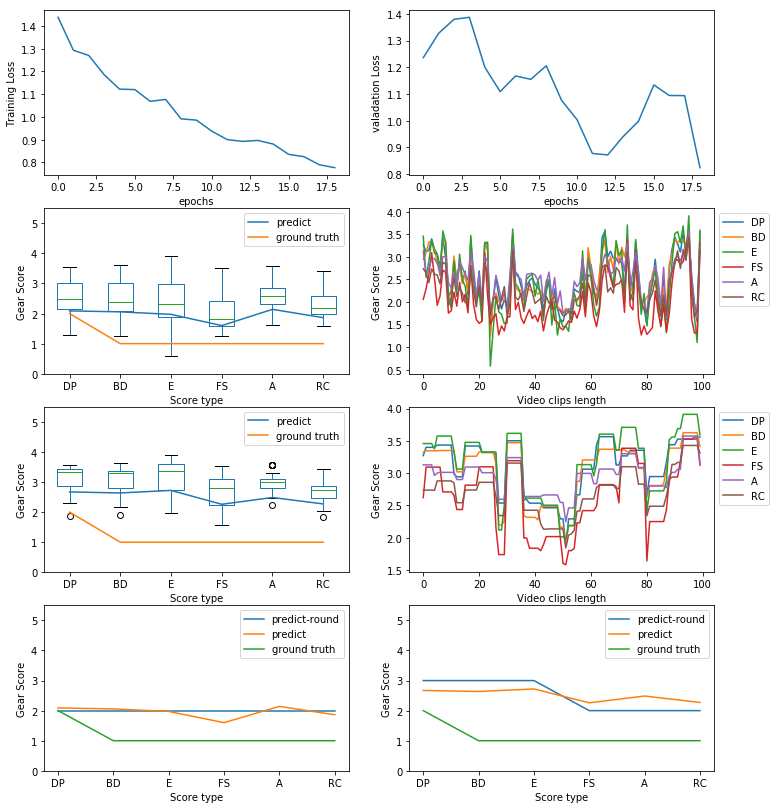

video 192 

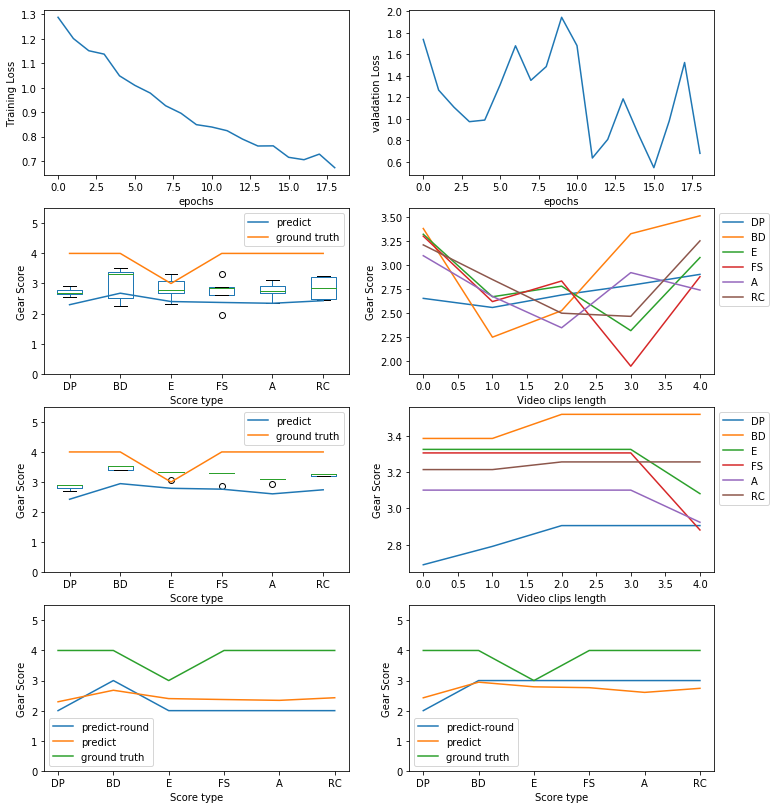

video 194 

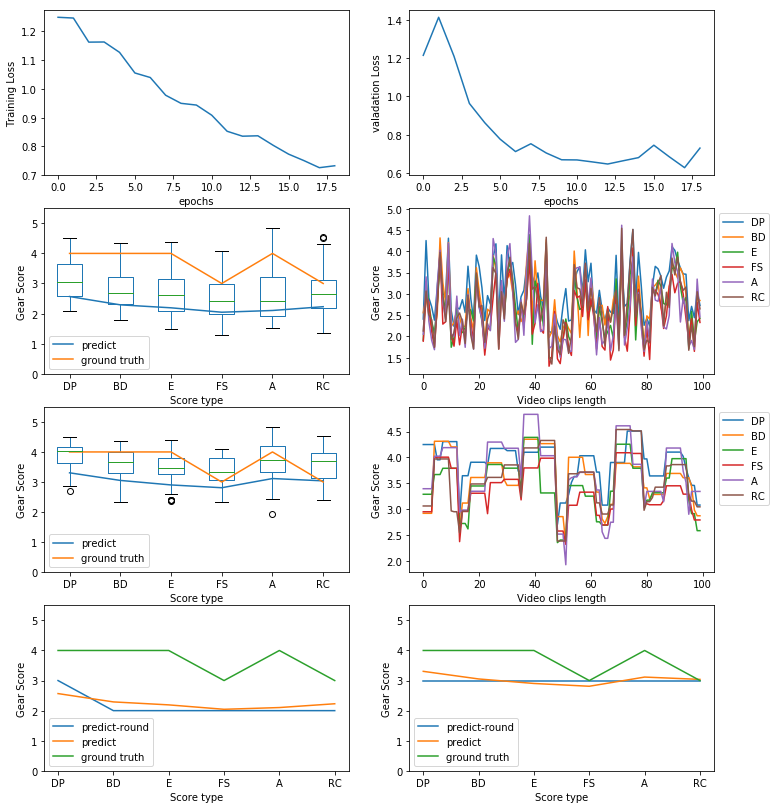

video 207 

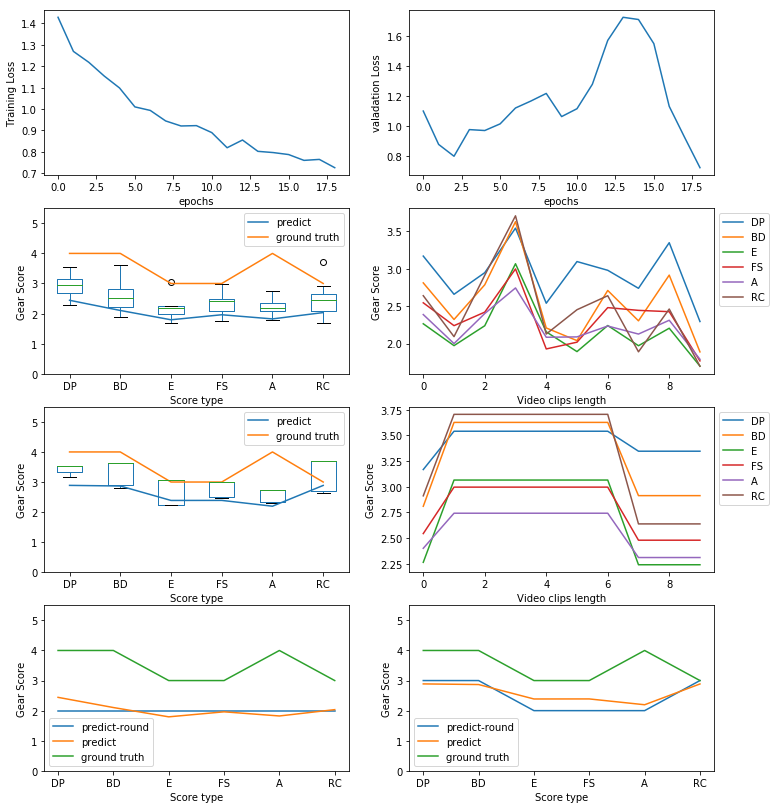

video 236 

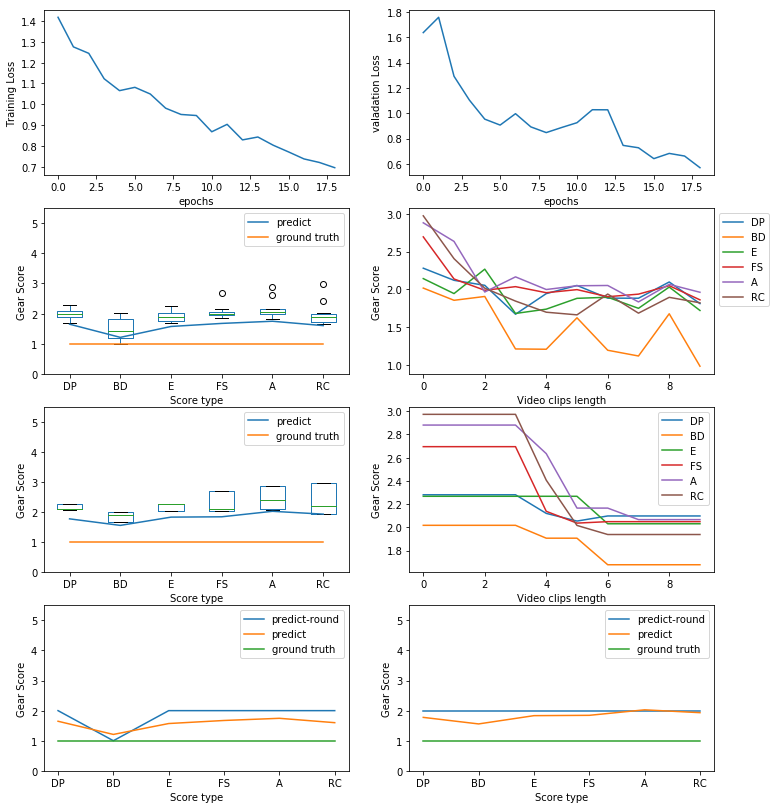

video 237 

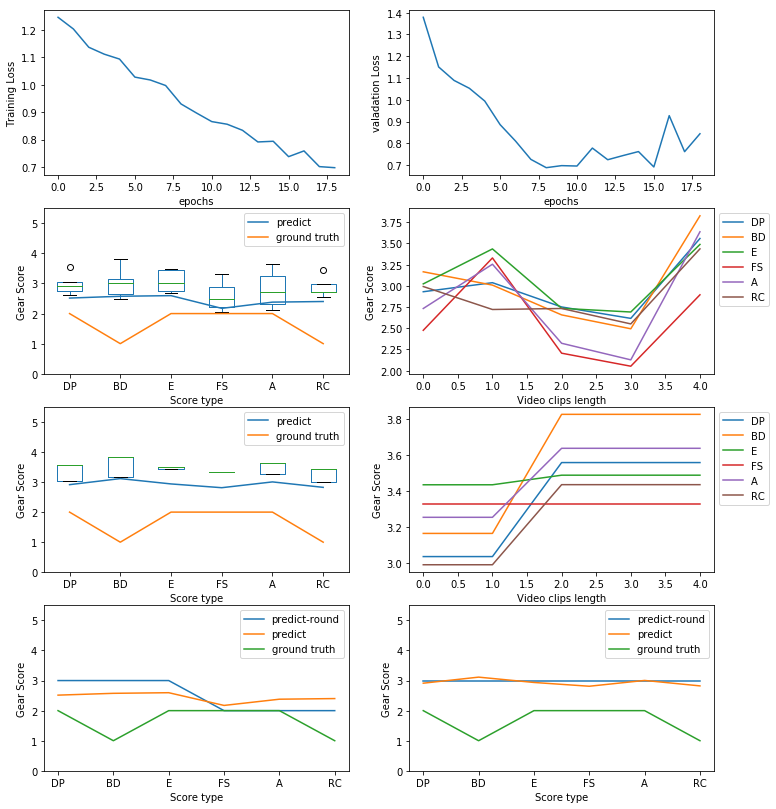

video 240 

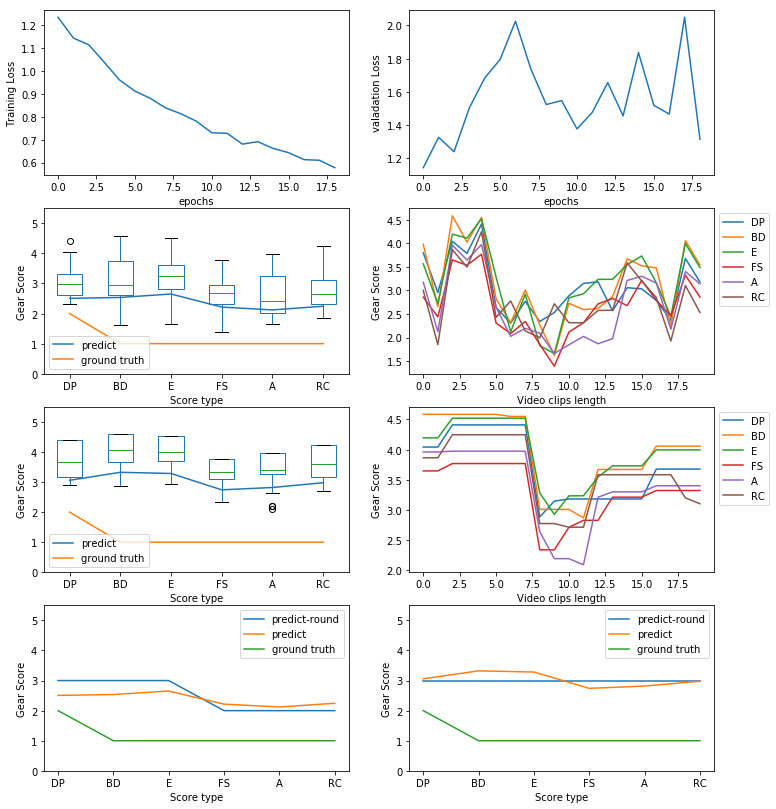

video 253 

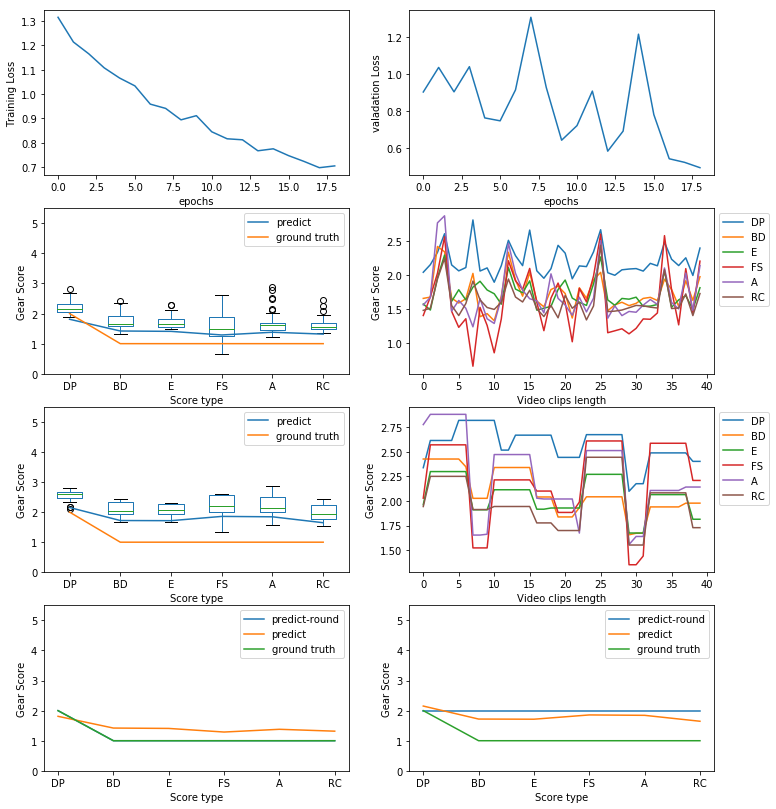

video 257 

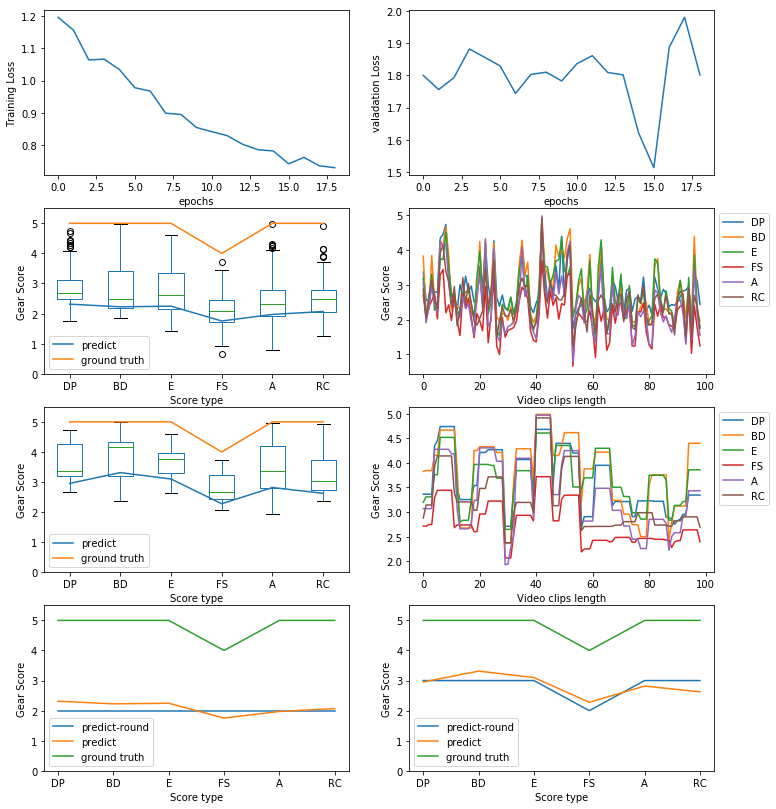

video 258 

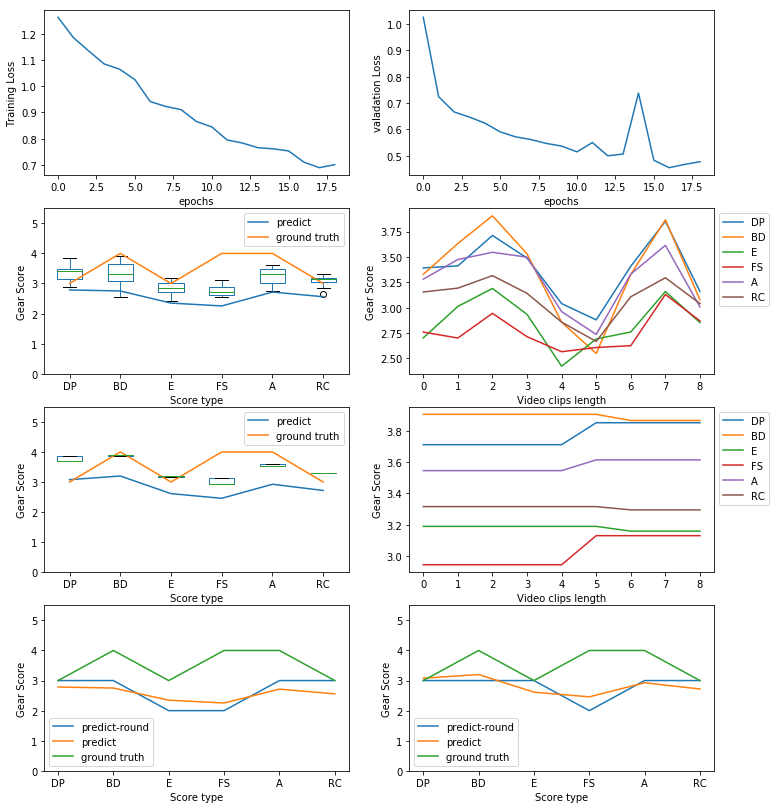

video 49 

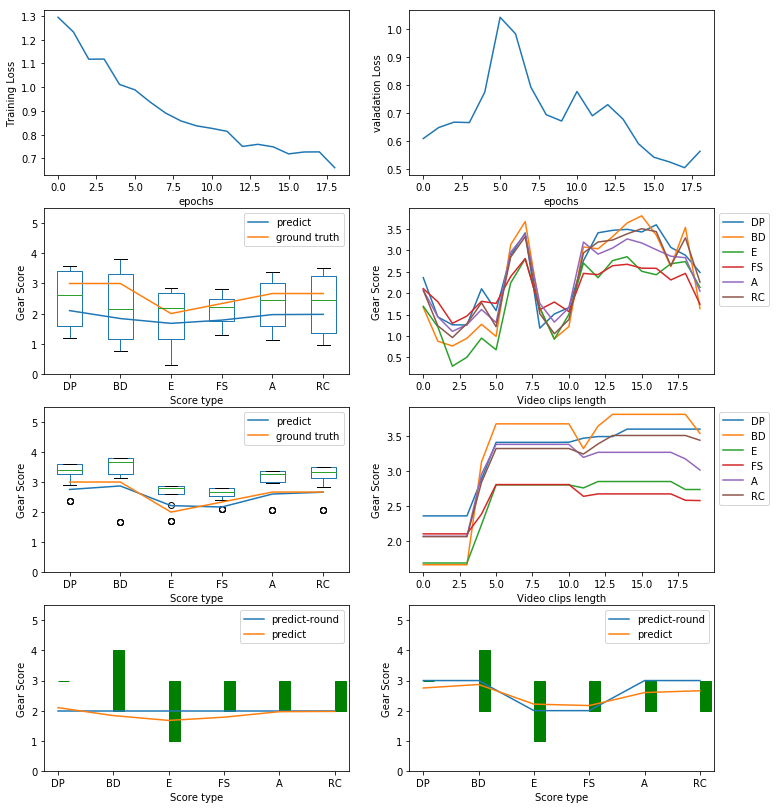

video 59 

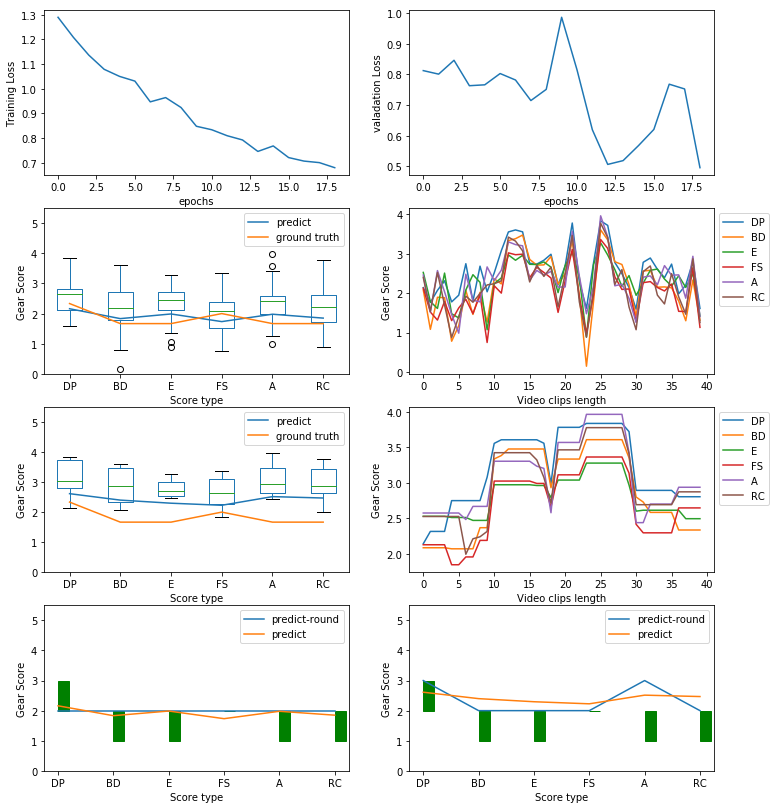

video 74 

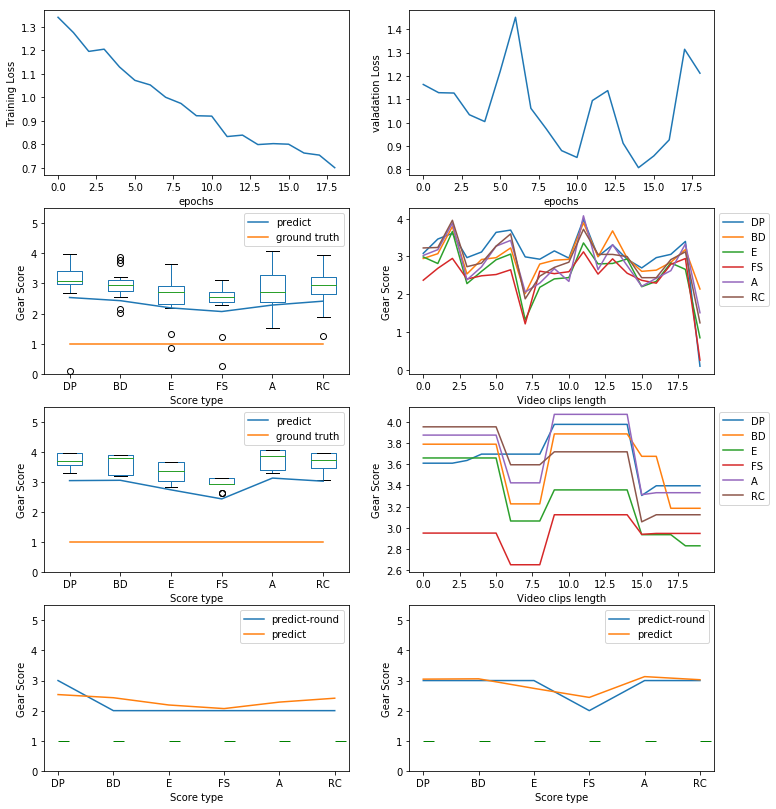

video 78 

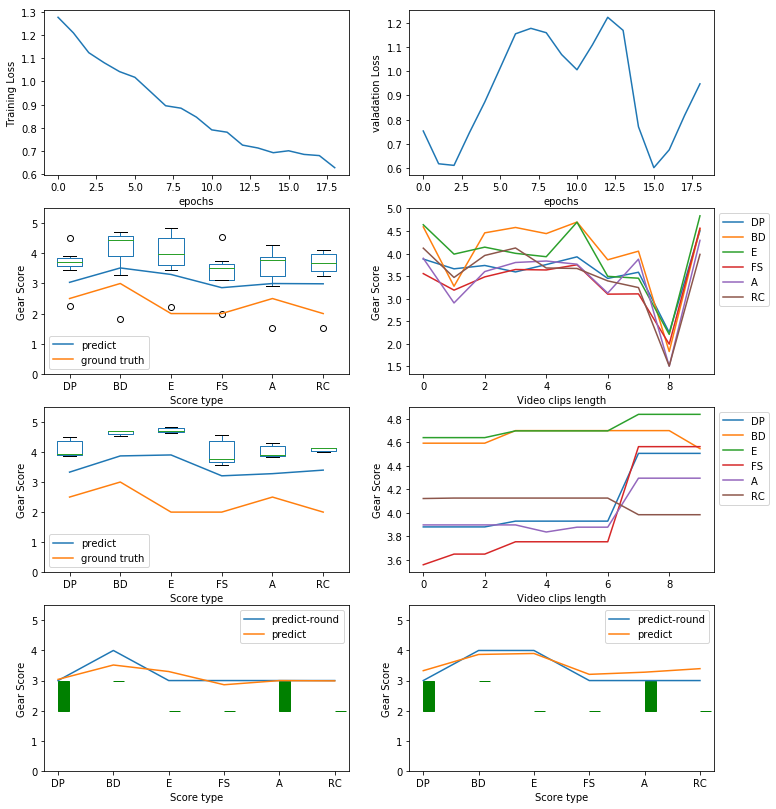

video 91 

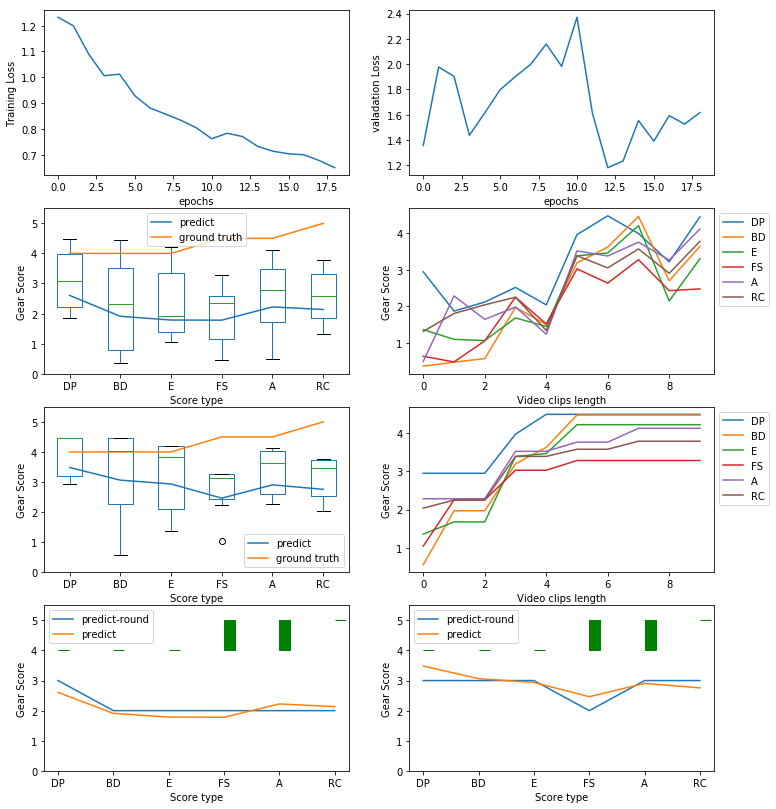

ValueError: Must pass 2-d input

In [69]:
Diff_plot=[]
fi_Diff_plot=[]
show_result=True
E=19
l2lam=0.01
noise_range=0.1
poolingweight=[0.333333,0.333333,0.333333]
stride=1
fsize=6
total_loss=0
model_name='CNN'
# for i in [11, 113, 130]:
for i in Y:
    print('video',i,end=' ')
    loss,each_diff,fi_each_diff=test_hold_out(model_name,i,E,show_result,l2lam,noise_range,poolingweight,stride,fsize)
#     print(np.sum(each_diff),np.sum(fi_each_diff))
    total_loss=total_loss+loss
    Diff_plot.append(each_diff)
    fi_Diff_plot.append(fi_each_diff)


Diff_plot=np.array(Diff_plot)
Diff_plot=pd.DataFrame(Diff_plot)
Diff_plot.columns = ['DP','BD','E','FS','A','RC']
Diff_plot.plot.box()
plt.ylim(0,4.5)
print('total_loss= ',total_loss)
print('all 6 gear score error',np.sum(Diff_plot))

In [ ]:
ave=[6.0,
 2.0,
 1.0,
 3.0,
 8.0,
 11.333333334,
 10.0,
 11.0,
 11.0,
 5.0,
 4.0,
 3.0,
 12.0,
 8.0,
 11.0,
 11.0,
 11.0,
 3.0,
 2.333333333,
 6.999999999000002,
 12.0,
 4.0,
 8.0]

In [ ]:
model_re=Diff_plot.sum(axis=1)
model_re=list(model_re)


In [ ]:
fi_Diff_plot=np.array(fi_Diff_plot)
fi_Diff_plot=pd.DataFrame(fi_Diff_plot)
fi_model_re=fi_Diff_plot.sum(axis=1)
fi_model_re=list(fi_model_re)

In [ ]:
import os
folder='data'
for each_model in os.listdir(folder):
    name=folder+'//'+each_model

    M=np.load(name)
    M=np.sum(M)
    print(name,M)


In [ ]:
import scipy.stats as stats
import scipy
best=np.load('data//20_0.0001_0.1_0_1_0_.npy')
print('total loss of average:',np.sum(ave))
print('total loss of model:',np.sum(model_re))
print('total loss of fi_model:',np.sum(fi_model_re))
print('best model!!',np.sum(best) )

In [ ]:
best_re=np.sum(best,axis=1)
best_re=list(best_re)

In [ ]:
# F = np.var(ave) / np.var(model_re)
# alpha = 0.05 #Or whatever you want your alpha to be.
# p_value = scipy.stats.f.cdf(F, ave, model_re)
# p_value

In [ ]:
stats.f_oneway(ave,best_re)

In [ ]:
best_re

In [ ]:
ave=[6.0,
 2.0,
 1.0,
 3.0,
 8.0,
 11.333333334,
 10.0,
 11.0,
 11.0,
 5.0,
 4.0,
 3.0,
 12.0,
 8.0,
 11.0,
 11.0,
 11.0,
 3.0,
 2.333333333,
 6.999999999000002,
 12.0,
 4.0,
 8.0]

In [ ]:
run JB test
F test each score
F test for all
use raw residual 
